In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline


# Create a random dataset
n_samples = 10000

rng = np.random.RandomState(123)
X = np.sort(200 * rng.rand(n_samples, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y += (0.5 - rng.rand(*y.shape))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=int(n_samples * 0.7), test_size=int(n_samples * 0.3), random_state=4)

In [2]:
print(X.shape, y.shape, X_train.shape, X_test.shape)

(10000, 1) (10000, 2) (7000, 1) (3000, 1)


## Random Forest for Multi-output Regression

In [3]:
max_depth = 50
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=1000,
                                                          max_depth=max_depth,
                                                          criterion="mse",
                                                          oob_score=True,
                                                          random_state=100))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, criterion="mse",
                                random_state=100)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

/Users/mpeng/anaconda3/envs/dev36/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


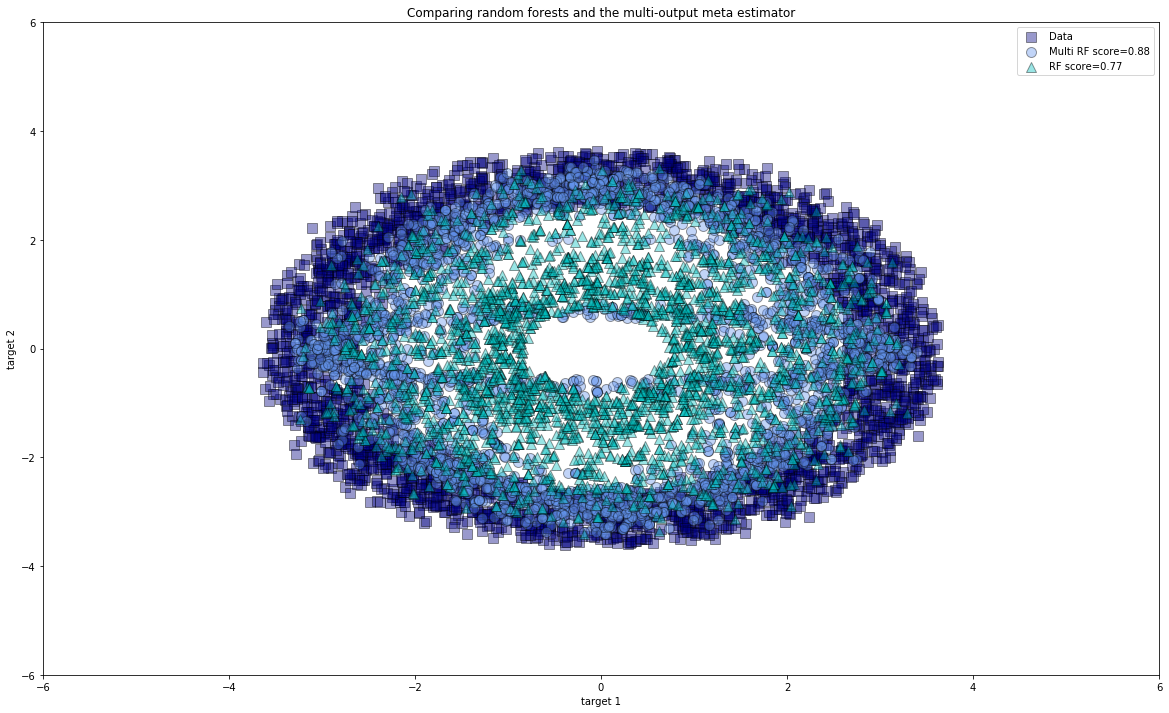

In [4]:
# Plot the results, it shows the RandomForest version with added MultiOutputRegressor shows same result

plt.figure(figsize=(20,12))
s = 100
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

## XGBoost for Multi-Output Regression

In [5]:
# Multioutput Regression Training using XGBoost

gbm = xgb.XGBRegressor(max_depth=max_depth, 
                       learning_rate=0.01,
                       n_estimators=500, 
                       objective='reg:squarederror',
                       booster='gbtree',
                       n_jobs=-1,
                       subsample = 0.63,
                       reg_alpha=0, 
                       reg_lambda=1, 
                       random_state=123)

regr_multilgb = MultiOutputRegressor(gbm)
regr_multilgb.fit(X_train, y_train)
# Predict on new data
y_multilgb = regr_multilgb.predict(X_test)

/Users/mpeng/anaconda3/envs/dev36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


In [6]:
def explain_score(y_pred, y, base_score=None):
    if base_score is None:
        base_score = y.mean(axis=0)
        base_score = np.vstack([base_score]*(y.shape[0])) + 0.
    a = np.sum(np.power(y_pred - y, 2))
    b = np.sum(np.power(y - base_score, 2))
    return 1 - a/b

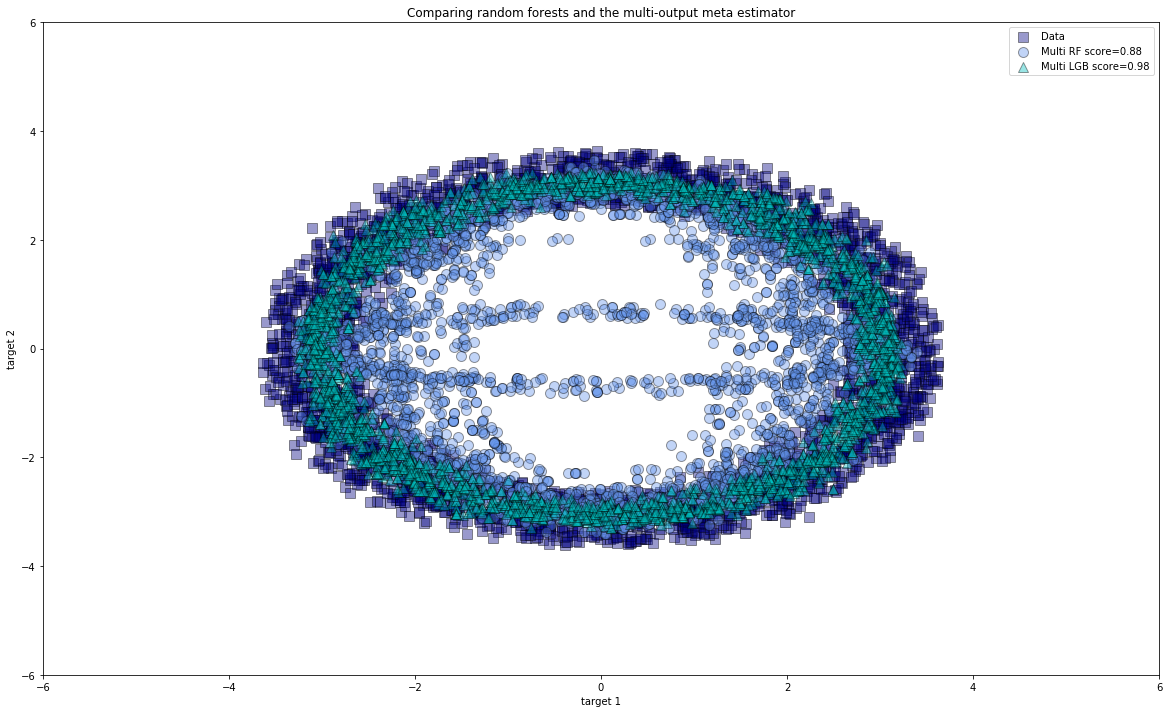

In [7]:
# Plot the results

y_hybrid_pred = 0.75 * y_multilgb + 0.25 * y_multirf

plt.figure(figsize=(20,12))
s = 100
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_multilgb[:, 0], y_multilgb[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="Multi LGB score=%.2f" % regr_multilgb.score(X_test, y_test))
#plt.scatter(y_hybrid_pred[:, 0], y_hybrid_pred[:, 1], edgecolor='k',
#            c="cornflowerblue", s=s, marker="o", alpha=a,
#            label="Multi Hybrid score=%.2f" % explain_score(y_hybrid_pred, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()